# Data Cleaning and MPI Index

In [2]:
from google.colab import auth
from google.auth import default
import gspread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

auth.authenticate_user()

creds, _ = default()
gc = gspread.authorize(creds)

In [22]:
sheet_url = 'https://docs.google.com/spreadsheets/d/1w5cG3JVeaItD1GDxKfa8iKbwpG4j0kKFqQrsnKRdM4k/edit?usp=sharing'
worksheet1 = gc.open_by_url(sheet_url).worksheet('AFE')
data = worksheet1.get_all_records()
df = pd.DataFrame(data)

In [23]:
print(df.head())

                  Country Name Country Code                   Indicator Name  \
0                        Aruba          ABW  Control of Corruption: Estimate   
1  Africa Eastern and Southern          AFE  Control of Corruption: Estimate   
2                  Afghanistan          AFG  Control of Corruption: Estimate   
3   Africa Western and Central          AFW  Control of Corruption: Estimate   
4                       Angola          AGO  Control of Corruption: Estimate   

     Topic short description long description Indicator Code Unit of measure  \
0  #ERROR!                                            CC.EST         #ERROR!   
1  #ERROR!                                            CC.EST         #ERROR!   
2  #ERROR!                                            CC.EST         #ERROR!   
3  #ERROR!                                            CC.EST         #ERROR!   
4  #ERROR!                                            CC.EST         #ERROR!   

       2000 2001  ...      2014      2

In [24]:
# Dropping rows that are missing more than 90% of required data
metadata_columns = df.columns[:8]
year_columns = df.columns[8:]
num_years = 24
df = df[(df[year_columns] == '').sum(axis=1) <= (num_years * 0.9)]
print(df.head())

  Country Name Country Code                   Indicator Name    Topic  \
0        Aruba          ABW  Control of Corruption: Estimate  #ERROR!   
2  Afghanistan          AFG  Control of Corruption: Estimate  #ERROR!   
4       Angola          AGO  Control of Corruption: Estimate  #ERROR!   
5      Albania          ALB  Control of Corruption: Estimate  #ERROR!   
6      Andorra          AND  Control of Corruption: Estimate  #ERROR!   

  short description long description Indicator Code Unit of measure      2000  \
0                                            CC.EST         #ERROR!             
2                                            CC.EST         #ERROR! -1.271724   
4                                            CC.EST         #ERROR! -1.197514   
5                                            CC.EST         #ERROR! -0.855564   
6                                            CC.EST         #ERROR!  1.313404   

  2001  ...      2014      2015      2016      2017      2018      2019  \

In [26]:
# Display all 87 indicators
all_indicators = df["Indicator Name"].unique()
i = 0
for indicator in all_indicators:
  print(indicator)
  i += 1
print(i)

Control of Corruption: Estimate
Multilateral debt service (% of public and publicly guaranteed debt service)
Access to clean fuels and technologies for cooking, rural (% of rural population)
Access to clean fuels and technologies for cooking, urban (% of urban population)
Access to clean fuels and technologies for cooking (% of population)
Access to electricity, rural (% of rural population)
Access to electricity, urban (% of urban population)
Access to electricity (% of population)
Compensation of employees (current LCU)
Compensation of employees (% of expense)
Adjusted savings: education expenditure (current US$)
Adjusted net national income per capita (current US$)
Terms of trade adjustment (constant LCU)
Adequacy of social protection and labor programs (% of total welfare of beneficiary households)
Adequacy of unemployment benefits and ALMP (% of total welfare of beneficiary households)
Adequacy of social safety net programs (% of total welfare of beneficiary households)
Adequacy o

In [27]:
education_keywords = ["literacy", "school", "enrollment"]
health_keywords = ["health", "mortality", "life expectancy", "clean fuels", "sanitation", "death"]
living_standards_keywords = ["electricity", "water", "social protection", "unemployment", "income"]

In [28]:
def matches_keywords(indicator_name, keywords):
    return any(keyword in str(indicator_name).lower() for keyword in keywords)

In [29]:
# Keeping only the indicators that include the above keywords
df = df[df["Indicator Name"].apply(lambda x:
                matches_keywords(x, education_keywords) or
                matches_keywords(x, health_keywords) or
                matches_keywords(x, living_standards_keywords))]
print(df["Indicator Name"].unique())

['Access to clean fuels and technologies for cooking, rural (% of rural population)'
 'Access to clean fuels and technologies for cooking, urban (% of urban population)'
 'Access to clean fuels and technologies for cooking (% of population)'
 'Access to electricity, rural (% of rural population)'
 'Access to electricity, urban (% of urban population)'
 'Access to electricity (% of population)'
 'Adjusted net national income per capita (current US$)'
 'Adequacy of social protection and labor programs (% of total welfare of beneficiary households)'
 'Adequacy of unemployment benefits and ALMP (% of total welfare of beneficiary households)'
 'Literacy rate, youth female (% of females ages 15-24)'
 'Literacy rate, youth (ages 15-24), gender parity index (GPI)'
 'Literacy rate, youth male (% of males ages 15-24)'
 'Literacy rate, youth total (% of people ages 15-24)'
 'Literacy rate, adult female (% of females ages 15 and above)'
 'Literacy rate, adult male (% of males ages 15 and above)'
 

In [30]:
# Fill in missing entries with the average for that row
for column in year_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df[year_columns] = df[year_columns].apply(lambda row: row.fillna(row.mean()), axis=1)

In [31]:
# New column to dataframe, Row_Average
df['Row_Average'] = df.iloc[:, 8:].mean(axis=1)
print(df.head())

                    Country Name Country Code  \
533  Africa Eastern and Southern          AFE   
534                  Afghanistan          AFG   
535   Africa Western and Central          AFW   
536                       Angola          AGO   
537                      Albania          ALB   

                                        Indicator Name    Topic  \
533  Access to clean fuels and technologies for coo...  #ERROR!   
534  Access to clean fuels and technologies for coo...  #ERROR!   
535  Access to clean fuels and technologies for coo...  #ERROR!   
536  Access to clean fuels and technologies for coo...  #ERROR!   
537  Access to clean fuels and technologies for coo...  #ERROR!   

    short description long description     Indicator Code Unit of measure  \
533                            #ERROR!  EG.CFT.ACCS.RU.ZS         #ERROR!   
534                            #ERROR!  EG.CFT.ACCS.RU.ZS         #ERROR!   
535                            #ERROR!  EG.CFT.ACCS.RU.ZS         #ERRO

In [32]:
# Define normalization functions
def normalize_positive(series):
    return (series.max() - series) / (series.max() - series.min())

def normalize_negative(series):
    return (series - series.min()) / (series.max() - series.min())

In [33]:
# Dictionary to classify indicators as positive or negative
# Negative indicators: THE HIGHER THE WORSE
negative_indicators = ['Children out of school, primary',
 'Children out of school, primary, female',
 'Children out of school, female (% of female primary school age)',
 'Children out of school, primary, male',
 'Children out of school, male (% of male primary school age)',
 'Children out of school (% of primary school age)',
 'Adolescents out of school, female (% of female lower secondary school age)',
 'Adolescents out of school, male (% of male lower secondary school age)',
 'Adolescents out of school (% of lower secondary school age)',
 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
 'Cause of death, by injury (% of total)',
 'Cause of death, by non-communicable diseases (% of total)',
 'Proportion of people living below 50 percent of median income (%)',
 'Unemployment with advanced education (% of total labor force with advanced education)',
 'Unemployment with basic education (% of total labor force with basic education)',
 'Unemployment with intermediate education (% of total labor force with intermediate education)',
 'Unemployment, total (% of total labor force) (national estimate)']

# Apply normalization within each indicator
def conditional_normalize(group):
    if group['Indicator Name'].iloc[0] in negative_indicators:
        group['Normalized_Row_Average'] = normalize_negative(group['Row_Average'])
    else:
        group['Normalized_Row_Average'] = normalize_positive(group['Row_Average'])
    return group

df = df.groupby('Indicator Name', group_keys=False).apply(conditional_normalize)

df.to_csv('normalized_dataset.csv', index=False)
print(df.head())

<ipython-input-33-0e25e62b53f9>:29: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



                    Country Name Country Code  \
533  Africa Eastern and Southern          AFE   
534                  Afghanistan          AFG   
535   Africa Western and Central          AFW   
536                       Angola          AGO   
537                      Albania          ALB   

                                        Indicator Name    Topic  \
533  Access to clean fuels and technologies for coo...  #ERROR!   
534  Access to clean fuels and technologies for coo...  #ERROR!   
535  Access to clean fuels and technologies for coo...  #ERROR!   
536  Access to clean fuels and technologies for coo...  #ERROR!   
537  Access to clean fuels and technologies for coo...  #ERROR!   

    short description long description     Indicator Code Unit of measure  \
533                            #ERROR!  EG.CFT.ACCS.RU.ZS         #ERROR!   
534                            #ERROR!  EG.CFT.ACCS.RU.ZS         #ERROR!   
535                            #ERROR!  EG.CFT.ACCS.RU.ZS         #ERRO

In [34]:
# Calculate the MPI for each country (average of all indicators)
mpi_df = df.groupby('Country Name')['Normalized_Row_Average'].mean().reset_index()

# Rename the column to MPI
mpi_df.rename(columns={'Normalized_Row_Average': 'MPI'}, inplace=True)

# Sort the countries by MPI
mpi_df = mpi_df.sort_values(by='MPI', ascending=False)

mpi_df.to_csv('mpi_results.csv', index=True)

print(mpi_df.head())



                 Country Name       MPI
221               South Sudan  0.830899
43                       Chad  0.767717
41   Central African Republic  0.750000
217                   Somalia  0.747868
127                    Kosovo  0.746777


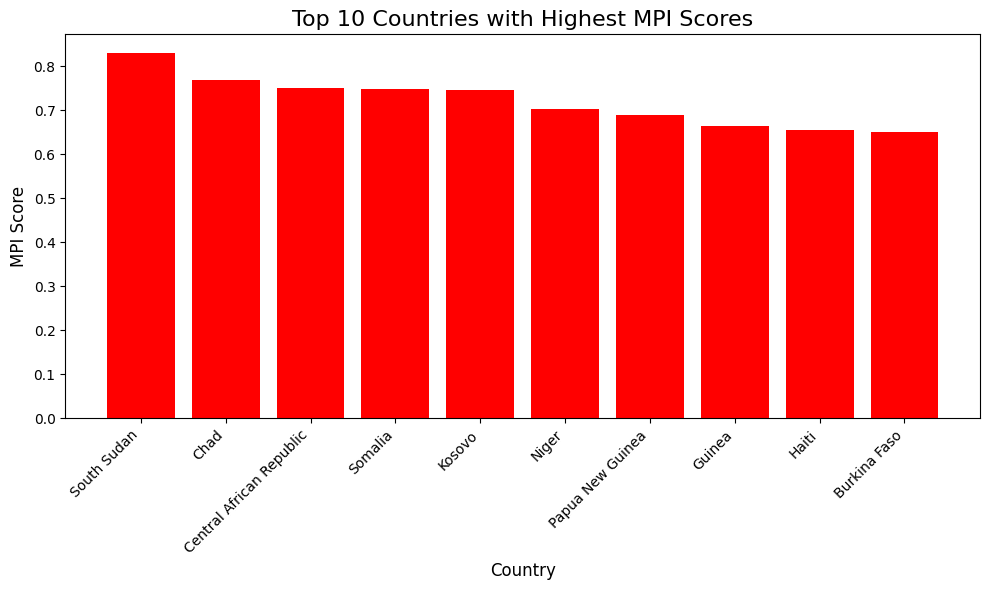

In [35]:
df = pd.read_csv("mpi_results.csv")

# Sort countries by MPI score (descending = highest poverty first)
df_sorted = df.sort_values(by="MPI", ascending=False)

# Plot Top 10 Countries with the Highest MPI Scores
plt.figure(figsize=(10, 6))
plt.bar(df_sorted["Country Name"].head(10), df_sorted["MPI"].head(10), color='red')
plt.title("Top 10 Countries with Highest MPI Scores", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("MPI Score", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px
mpi_df = pd.read_csv("mpi_results.csv")

mpi_df['Country Name'] = mpi_df['Country Name'].replace({
    'United States of America': 'United States',
    'South Korea': 'Korea, South',
    'North Korea': 'Korea, North',
    'Czech Republic': 'Czechia',
    'Ivory Coast': "Côte d'Ivoire"
})

fig = px.choropleth(
    df,
    locations="Country Name",
    locationmode="country names",
    color="MPI",
    hover_name="Country Name",
    color_continuous_scale="Reds",
    title="Global Multidimensional Poverty Index (MPI)",
    range_color=(0, 1)
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title="MPI Score")
)

fig.show()
fig.write_html("mpi_choropleth_interactive.html")

# Indicator Analysis

In [ ]:
import pandas as pd

file_path = 'normalized_dataset.csv'
data = pd.read_csv(file_path)

# Changing the data into a wide format
wide_data = data.pivot(index='Country Name', columns='Indicator Name', values='Normalized_Row_Average')
wide_data.reset_index(inplace=True)

# Cleaning the wide dataset
print("Missing values before imputation:")
print(wide_data.isnull().sum())

indicator_columns = wide_data.columns.drop('Country Name')

wide_data[indicator_columns] = wide_data[indicator_columns].apply(pd.to_numeric, errors='coerce')

wide_data[indicator_columns] = wide_data[indicator_columns].apply(lambda row: row.fillna(row.mean()), axis=1)

print("\nMissing values after imputation:")
print(wide_data.isnull().sum())

output_file_path = 'cleaned_wide_data.csv'
wide_data.to_csv(output_file_path, index=False)

print(wide_data.head())

Missing values before imputation:
Indicator Name
Country Name                                                                                               0
Access to clean fuels and technologies for cooking (% of population)                                      28
Access to clean fuels and technologies for cooking, rural (% of rural population)                         28
Access to clean fuels and technologies for cooking, urban (% of urban population)                         28
Access to electricity (% of population)                                                                    2
Access to electricity, rural (% of rural population)                                                       4
Access to electricity, urban (% of urban population)                                                       4
Adequacy of social protection and labor programs (% of total welfare of beneficiary households)          208
Adequacy of unemployment benefits and ALMP (% of total welfare of beneficiary h

In [40]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

indicators_file_path = 'cleaned_wide_data.csv'
mpi_file_path = 'mpi_results.csv'
indicators_data = pd.read_csv(indicators_file_path)
mpi_data = pd.read_csv(mpi_file_path)

# Merging the mpi dataset and the wide dataset
combined_data = pd.merge(indicators_data, mpi_data, on='Country Name', how='left')

# Setting up Random Forest
X = combined_data.drop(columns=['Country Name', 'MPI'])
y = combined_data['MPI']

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Analyzing feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
print("\nFeature Importances:")
print(importances_sorted)

output_file_path = 'combined_data.csv'
combined_data.to_csv(output_file_path, index=True)
print(f"\nCombined data has been saved to {output_file_path}")


Feature Importances:
Access to electricity (% of population)                                                                  0.360842
Adequacy of unemployment benefits and ALMP (% of total welfare of beneficiary households)                0.179283
Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)    0.135553
Community health workers (per 1,000 people)                                                              0.091357
Access to electricity, rural (% of rural population)                                                     0.043079
People using at least basic sanitation services (% of population)                                        0.035950
Literacy rate, adult female (% of females ages 15 and above)                                             0.035771
Adequacy of social protection and labor programs (% of total welfare of beneficiary households)          0.030526
Literacy rate, adult total (% of people ages 15 and above)        

<ipython-input-41-3d2af1c05dc4>:16: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



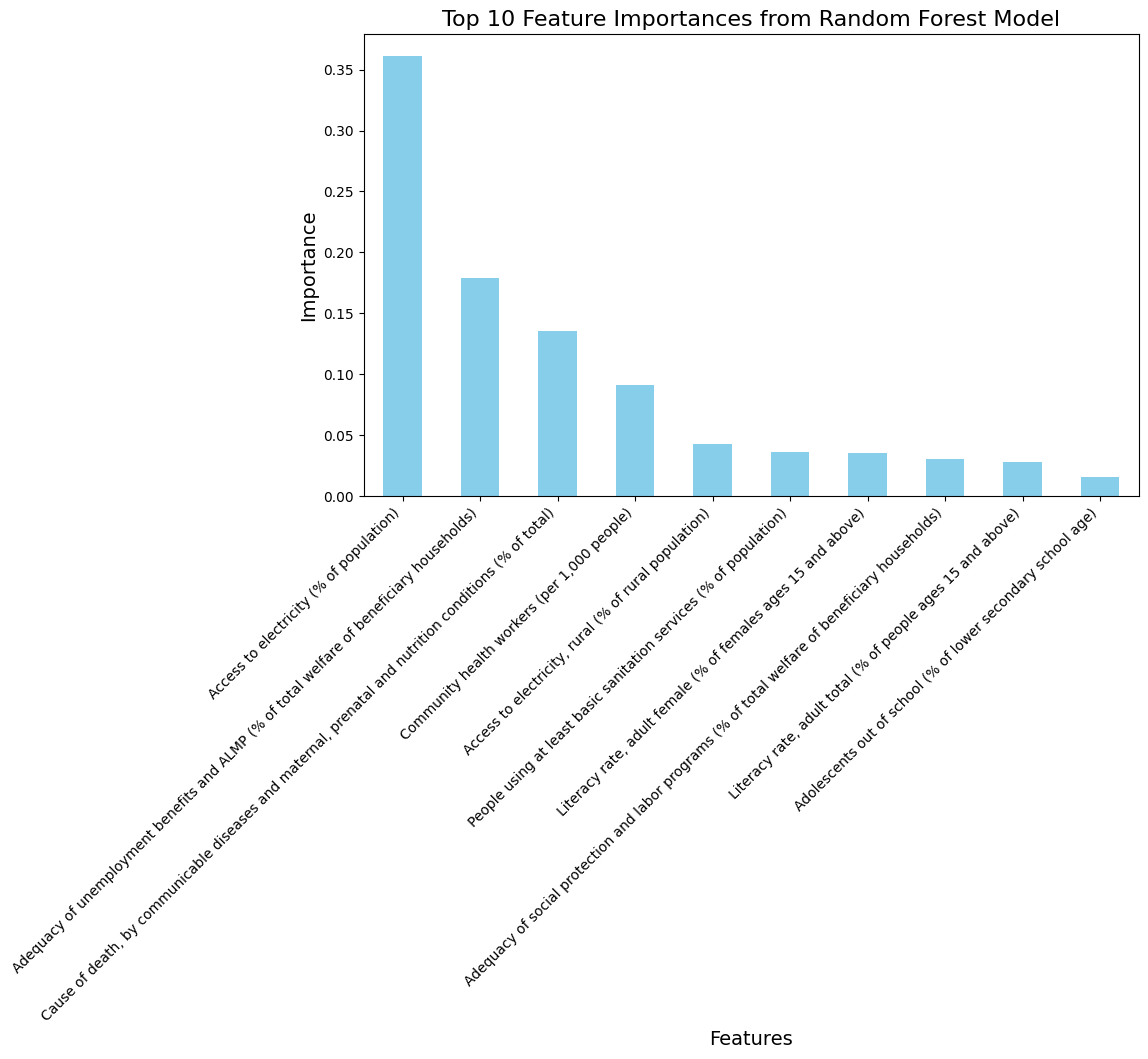

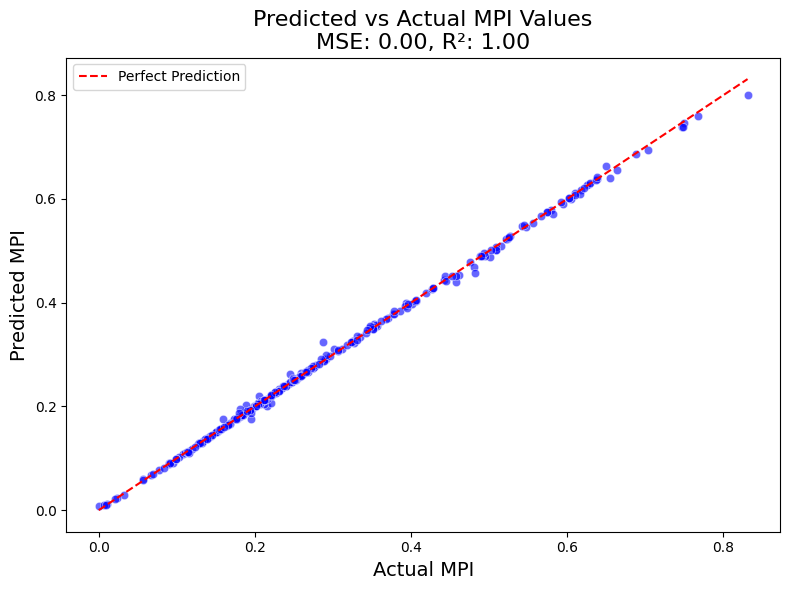

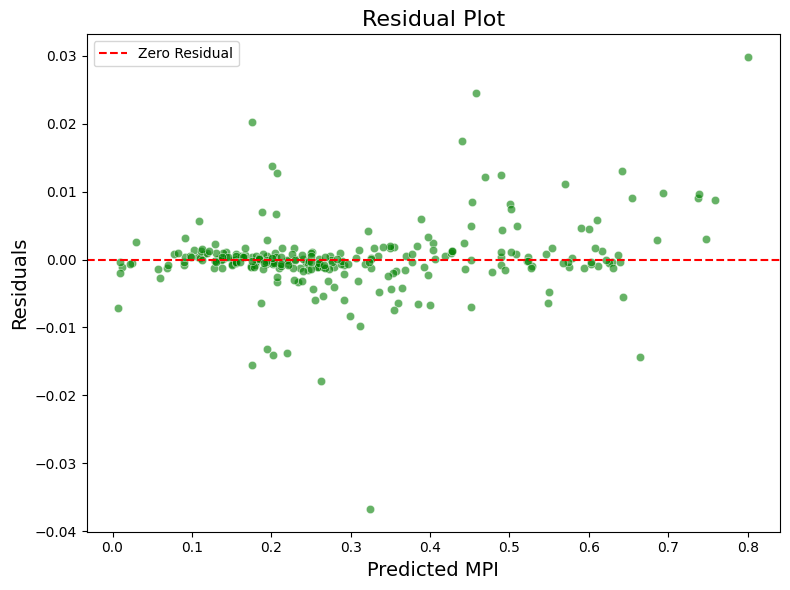

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Data Display

# 1. Feature Importances Plot
plt.figure(figsize=(10, 6))
top_10_importances = importances_sorted.head(10)  # Selecting the top 10 features
top_10_importances.plot(kind='bar', color='skyblue')
plt.title('Top 10 Feature Importances from Random Forest Model', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Predicted vs Actual MPI Values Plot
y_pred = model.predict(X)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Predicted vs. Actual MPI values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title(f'Predicted vs Actual MPI Values\nMSE: {mse:.2f}, R²: {r2:.2f}', fontsize=16)
plt.xlabel('Actual MPI', fontsize=14)
plt.ylabel('Predicted MPI', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Residual Plot
residuals = y - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, color='green', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual')
plt.title('Residual Plot', fontsize=16)
plt.xlabel('Predicted MPI', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()